In [1]:
#Import standard packages
import pandas as pd
import numpy as np
import xarray as xr
import math

import os
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from pyaldata import *

import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
from sklearn.metrics import r2_score
import pickle
from tqdm import tqdm
import csv

#Import function to get the covariate matrix that includes spike history from previous bins
from Neural_Decoding.preprocessing_funcs import get_spikes_with_history

#Import decoder functions
from Neural_Decoding.decoders import KalmanFilterDecoder
from Neural_Decoding.decoders import SVClassification

In [2]:
# Function that reassigns different angles into classes from 1 to 8
# going anticlockwise starting from +x direction
def determine_angle(angle):
    if angle == 0:
        return 1
    elif angle == math.pi/4:
        return 2
    elif angle == math.pi/2:
        return 3
    elif angle == 3*math.pi/4:
        return 4
    elif angle == math.pi:
        return 5
    elif angle == -3*math.pi/4:
        return 6
    elif angle == -math.pi/2:
        return 7
    elif angle == -math.pi/4:
        return 8

In [3]:
# Load data
data_dir = '../raw_data/'
fname = os.path.join(data_dir, "Chewie_CO_CS_2016-10-14.mat")

# load TrialData .mat file into a DataFrame
df = mat2dataframe(fname, shift_idx_fields=True)

# Keep only successful trials
df = select_trials(df, "result == 'R'")

In [4]:
## Classification preprocessing

# Preprocessing
# combine time bins into longer ones, e.g. group 3 time bins together
td_class = combine_time_bins(df, 3)

# Obtain only the interval between idx_target_on and idx_go_cue
td_class = restrict_to_interval(td_class, start_point_name='idx_target_on', end_point_name='idx_go_cue')

# Remove low-firing neurons
td_class = remove_low_firing_neurons(td_class, "M1_spikes",  5)
td_class = remove_low_firing_neurons(td_class, "PMd_spikes", 5)

# total number of trials
N = td_class.shape[0]

#Number of M1_neurons
N_M1 = td_class.M1_spikes[0].shape[1]
#Number of PMd_neurons
N_PMd = td_class.PMd_spikes[0].shape[1]

M1_spikes = np.empty([N_M1,N])
PMd_spikes = np.empty([N_PMd,N])
y = np.empty([N,1])

for i in range(N):
    # Get the neuron spikes for a given trial in train data
    M1_trial = np.transpose(td_class.M1_spikes[i])
    PMd_trial = np.transpose(td_class.PMd_spikes[i])
    
    # Sum all the spikes in the given trial and save them
    M1_spikes[:,i] = np.sum(M1_trial, axis=1)
    PMd_spikes[:,i] = np.sum(PMd_trial, axis=1)
    
    # Get the label
    y[i] = determine_angle(td_class.target_direction[i])
    
# Build a feature vector
F_M1 = np.empty([N, N_M1])
F_PMd = np.empty([N, N_PMd])
for i in range(N):#in range(M1_spikes.shape[1]):
    total_M1_spikes = np.sum(M1_spikes[:,i]);
    total_PMd_spikes = np.sum(PMd_spikes[:,i])
    
    f_M1 = np.transpose(M1_spikes[:,i])/total_M1_spikes
    f_PMd = np.transpose(PMd_spikes[:,i])/total_PMd_spikes
    
    # Store average firing rates
    F_M1[i,:] = f_M1
    F_PMd[i,:] = f_PMd
    
# Combine M1 and PMd features
F_M1_PMd = np.concatenate((F_M1, F_PMd), axis = 1)

c:\users\jon\documents\biomedical engineering - ic\4. letnik\final year project\python\pyaldata\pyaldata\tools.py:979: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


In [5]:
# Split the data into test and train subsets
split = int(0.8*N)

y_train = y[0:split-1]
y_test = y[split:]

F_M1_PMd_train = F_M1_PMd[0:split-1,:]
F_M1_PMd_test = F_M1_PMd[split:,:]


## Train classifiers
# Support vector classification
sv_classifier = SVClassification()

sv_classifier.fit(F_M1_PMd_train, np.squeeze(y_train))


In [6]:
folder='../preprocessed_data/'
#ENTER THE FOLDER THAT YOUR DATA IS IN

with open(folder+'all_data.pickle','rb') as f:
    M1, PMd, M1_PMd,pos_binned,vels_binned=pickle.load(f,encoding='latin1') #If using python 3

neural_data = M1
kinematics = [pos_binned, vels_binned]

X_mean_all = np.empty((2,441))
X_std_all = np.empty((2,441))
Output_all_mean = np.empty((2,2))
for i,output in enumerate(kinematics):
    # Preprocess data
    bins_before=6 #How many bins of neural data prior to the output are used for decoding
    bins_current=1 #Whether to use concurrent time bin of neural data
    bins_after=0 #How many bins of neural data after the output are used for decoding

    # Format for recurrent neural networks (SimpleRNN, GRU, LSTM)
    # Function to get the covariate matrix that includes spike history from previous bins
    X=get_spikes_with_history(neural_data,bins_before,bins_after,bins_current)

    # Format for Wiener Filter, Wiener Cascade, XGBoost, and Dense Neural Network
    #Put in "flat" format, so each "neuron / time" is a single feature
    X_flat=X.reshape(X.shape[0],(X.shape[1]*X.shape[2]))

    # Output covariates
    #Set decoding output
    y=output

    # Split into training / testing / validation sets
    #Set what part of data should be part of the training/testing/validation sets
    training_range=[0, 0.8]
    valid_range=[0.8,1]

    # Split data:
    num_examples=X.shape[0]

    #Note that each range has a buffer of"bins_before" bins at the beginning, and "bins_after" bins at the end
    #This makes it so that the different sets don't include overlapping neural data
    training_set=np.arange(int(np.round(training_range[0]*num_examples))+bins_before,int(np.round(training_range[1]*num_examples))-bins_after)
    valid_set=np.arange(int(np.round(valid_range[0]*num_examples))+bins_before,int(np.round(valid_range[1]*num_examples))-bins_after)

    #Get training data

    X_flat_train=X_flat[training_set,:]
    y_train=y[training_set,:]

    #Get validation data
    X_flat_valid=X_flat[valid_set,:]
    y_valid=y[valid_set,:]

    #Z-score "X_flat" inputs. 
    X_flat_mean_all[i]=np.nanmean(X_flat_train,axis=0)
    X_flat_std_all[i]=np.nanstd(X_flat_train,axis=0)

    #Zero-center outputs
    Output_all_mean[i]=np.mean(y_train,axis=0)


NameError: name 'X_flat_mean_all' is not defined

In [7]:
## Regression training
folder='../preprocessed_data/'
#ENTER THE FOLDER THAT YOUR DATA IS IN

with open(folder+'individual_tar_data.pickle','rb') as f:
    M1, M1_PMd,pos_binned,vels_binned,sizes,trial_len=pickle.load(f,encoding='latin1') #If using python 3

neural_data = M1

KF_models = []

# get number of targets
N = sizes.size

# User 
lag=0 #What time bin of spikes should be used relative to the output
#(lag=-1 means use the spikes 1 bin before the output)


start = 0
end = sum(trial_len[0:sizes[0]])
# Loop over the data to obtain decoders for all 8 targets
for tar in tqdm(range(1, N+1)): 

    X_kf = neural_data[start:end]
    #The final output covariates include position, velocity, and acceleration
    y_kf=np.concatenate((pos_binned[start:end,:],vels_binned[start:end,:]),axis=1)
    
    
    # Take into account lag (if it applies to the analysis)
    num_examples_kf=X_kf.shape[0]

    #Re-align data to take lag into account
    if lag<0:
        y_kf=y_kf[-lag:,:]
        X_kf=X_kf[0:num_examples+lag,:]
    if lag>0:
        y_kf=y_kf[0:num_examples-lag,:]
        X_kf=X_kf[lag:num_examples,:]
    
    
    # Split into training / testing / validation sets
    #Set what part of data should be part of the training/testing/validation sets
    training_range=[0, 0.8]
    #testing_range=[0.7, 0.85]
    valid_range=[0.8,1]

    # Split data:
    num_examples_kf=X_kf.shape[0]

    ##Note that each range has a buffer of 1 bin at the beginning and end
    #This makes it so that the different sets don't include overlapping data
    training_set=np.arange(int(np.round(training_range[0]*num_examples_kf))+1,int(np.round(training_range[1]*num_examples_kf))-1)
    #testing_set=np.arange(int(np.round(testing_range[0]*num_examples_kf))+1,int(np.round(testing_range[1]*num_examples_kf))-1)
    valid_set=np.arange(int(np.round(valid_range[0]*num_examples_kf))+1,int(np.round(valid_range[1]*num_examples_kf))-1)

    #Get training data
    X_kf_train=X_kf[training_set,:]
    y_kf_train=y_kf[training_set,:]

    #Get testing data
    #X_kf_test=X_kf[testing_set,:]
    #y_kf_test=y_kf[testing_set,:]

    #Get validation data
    X_kf_valid=X_kf[valid_set,:]
    y_kf_valid=y_kf[valid_set,:]
    
    #  Preprocessing: Normalization and zero-centering
    #Z-score inputs 
    #X_kf_train_mean=np.nanmean(X_kf_train,axis=0)
    #X_kf_train_std=np.nanstd(X_kf_train,axis=0)
    #X_kf_train=(X_kf_train-X_kf_train_mean)/X_kf_train_std
    #X_kf_test=(X_kf_test-X_kf_train_mean)/X_kf_train_std
    #X_kf_valid=(X_kf_valid-X_kf_train_mean)/X_kf_train_std

    #Zero-center outputs
    #y_kf_train_mean=np.mean(y_kf_train,axis=0)
    #y_kf_train=y_kf_train-y_kf_train_mean
    #y_kf_test=y_kf_test-y_kf_train_mean
    #y_kf_valid=y_kf_valid-y_kf_train_mean

    # Run decoder
    # Declare model
    model_kf=KalmanFilterDecoder(C=1) #There is one optional parameter that is set to the default in this example (see ReadMe)

    #Fit model
    model_kf.fit(X_kf_train,y_kf_train)
    
    KF_models.append(model_kf)
    
    # Find new indexes based on trial_len and sizes variables
    start = end
    new_elements = sum(trial_len[sum(sizes[0:tar]):sum(sizes[0:tar+1])])
    end = end + new_elements

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 129.98it/s]


In [8]:
# Import the whole data set
# combine time bins into longer ones
td_full = combine_time_bins(df, 3)

# Remove low-firing neurons
td_full = remove_low_firing_neurons(td_full, "M1_spikes",  5)
td_full = remove_low_firing_neurons(td_full, "PMd_spikes", 5)

# Get the signal from idx_go_cue
df.idx_movement_on = df.idx_movement_on.astype(int)
td_full = restrict_to_interval(td_full, start_point_name='idx_go_cue', end_point_name='idx_trial_end')


td_full = smooth_signals(td_full, ["M1_spikes", "PMd_spikes"], std=0.05)
 


c:\users\jon\documents\biomedical engineering - ic\4. letnik\final year project\python\pyaldata\pyaldata\tools.py:979: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


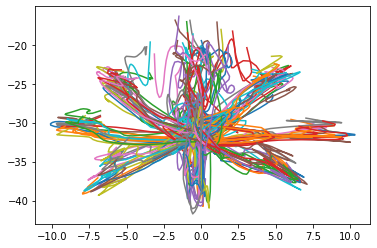

In [12]:
## Make predictions
N_trials = 740
start = 0
kinematics = [td_full.pos, td_full.vel]


predictions = []
y_valid_full = []
y_pred_full = []
for i in range(N_trials-int(0.8*N_trials)):
    #end = start + trial - 1
    #print(int(0.8*N_trials),i)
    X_kf = td_full.M1_spikes[int(0.8*N_trials)+i]
    
    y_valid = np.concatenate((td_full.pos[int(0.8*N_trials)+i],td_full.pos[int(0.8*N_trials)+i]),axis=1)
    
    # Predict the angle
    # perfect prediciton:
    #class_prediction =y_test[i]
    # using classifier to predict
    class_prediction = sv_classifier.predict([F_M1_PMd_test[i]])
    predictions.append(class_prediction)


    # Take into account lag (if it applies to the analysis)
    num_examples_kf=X_kf.shape[0]

    #Re-align data to take lag into account
    if lag<0:
        y_kf=y_kf[-lag:,:]
        X_kf=X_kf[0:num_examples+lag,:]
    if lag>0:
        y_kf=y_kf[0:num_examples-lag,:]
        X_kf=X_kf[lag:num_examples,:]
    
    X_kf_final = np.nan_to_num(X_kf)
    
    #X_kf_final_mean = np.nanmean(X_kf, axis=0)
    #X_kf_final_std = np.nanstd(X_kf, axis=0)
    #X_kf_final = (X_kf-X_kf_final_mean)/X_kf_final_std


    

   # X_flat_final = (X_flat_final-x_flat_mean[int(class_prediction-1)])/x_flat_std[int(class_prediction-1)]
    #y_valid_mean = np.mean(y_valid,axis=0)
    #y_valid = y_valid-y_valid_mean

    # Avoid some errors
    #if X_flat_final.shape[0] == 0:
     #   continue

    y_valid_predicted = KF_models[int(class_prediction-1)].predict(X_kf_final, y_valid)


    y_valid_full.append(y_valid)
    y_pred_full.append(y_valid_predicted)

    # Update the starting point of the data for next iteration of the loop

    y_pred_plot = y_valid_predicted
    plt.plot(np.transpose(y_pred_plot[:,0]), np.transpose(y_pred_plot[:,1]))



In [13]:
y_valid_full = np.array(y_valid_full)
y_pred_full = np.array(y_pred_full)


for i in range(y_valid_full.shape[0]):
    if i == 0:
        y_val = np.array(np.squeeze(y_valid_full[i]))
        y_pred = np.array(np.squeeze(y_pred_full[i]))
    else:
        y_val = np.concatenate((y_val, np.squeeze(y_valid_full[i])), axis=0)
        y_pred = np.concatenate((y_pred, np.squeeze(y_pred_full[i])), axis=0)

#R2_vw = r2_score(y_val,y_pred, multioutput='variance_weighted')
    #print('R2 value:', R2_vw)

c:\users\jon\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
c:\users\jon\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [14]:
R2_pos_vw = r2_score(y_val[:,0:2],np.nan_to_num(y_pred[:,0:2]), multioutput='variance_weighted')
R2_vel_vw = r2_score(y_val[:,2:4],np.nan_to_num(y_pred[:,2:4]), multioutput='variance_weighted')
print(R2_pos_vw, R2_vel_vw)

0.776475661131437 -27.531633450793464
